In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from matplotlib import patches
import matplotlib.pyplot as plt
from astropy import cosmology
from astropy.io import fits
from astropy import table
import SAGA

In [3]:
plt.rcParams['font.size'] = 16

In [4]:
cosmo = cosmology.FlatLambdaCDM(70.,0.3)

In [5]:
saga = SAGA.QuickStart(local_dir='../local_data/')
#'/path/to/saga/dropbox/folder', '/path/to/saga/local/folder')

SAGA `shared_dir` set to /Users/kadofong/work/surveys/saga/notebooks
SAGA `local_dir`  set to ../local_data/


In [6]:
saga.database["combined_base"].remote.path = "https://drive.google.com/uc?export=download&id=1WnGUfDCZwXEUsy4zgGFR1ez3ZE5DFtsB&confirm=t&uuid=d0f82ed0-6db5-4ca0-bb8f-6c54d44a17db"

In [7]:
saga.database["combined_base"].download(overwrite=False)

In [8]:
base = saga.object_catalog.load_combined_base_catalog()
base = saga.host_catalog.construct_host_query("paper3").filter(base)

# Found Yao's targeting code

In [9]:
from SAGA import targets

In [10]:
out = targets.assign_targeting_score.assign_targeting_score_v3 ( base, ignore_specs=True)

In [11]:
cleaner = (base['REMOVE']==0)&base['is_galaxy']&(base['ZQUALITY']>=3)
clean = base[cleaner]
#target_score = out[cleaner]['TARGETING_SCORE']
#saga_primary = clean[(target_score<=700)].to_pandas ().set_index('OBJID')
#saga_relaxed = clean[(target_score>700)&(target_score<=1000)].to_pandas().set_index('OBJID')

target_score = base[cleaner]['TARGETING_SCORE']

clean['target_score'] = target_score

In [12]:
import pandas as pd

In [13]:
tele = pd.read_csv('/Users/kadofong/Downloads/tele20220310.csv', index_col=0)

(-5.0, 5.0)

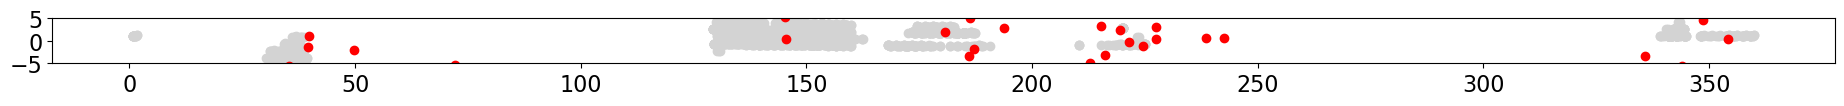

In [14]:
fig = plt.figure (figsize=(23,4))
ax = plt.subplot(111)
ax.set_aspect('equal')
hosts = saga.host_catalog.load("paper3", include_stats=True)


plt.scatter ( tele['ra'], tele['declination'], color='lightgrey')
plt.scatter ( hosts['RA'], hosts['DEC'], label='SAGA', color='r' )
plt.ylim(-5,5)

In [15]:
hostname = np.unique(base['HOSTID'])[3]
this_host = base[base['HOSTID']==hostname].to_pandas ()
target_score = base[base['HOSTID']==hostname]['TARGETING_SCORE']

In [21]:
radius = np.mean([this_host['RA'].max() - this_host['RA'].min(),this_host['DEC'].max() - this_host['DEC'].min(),])/2.

21.016287


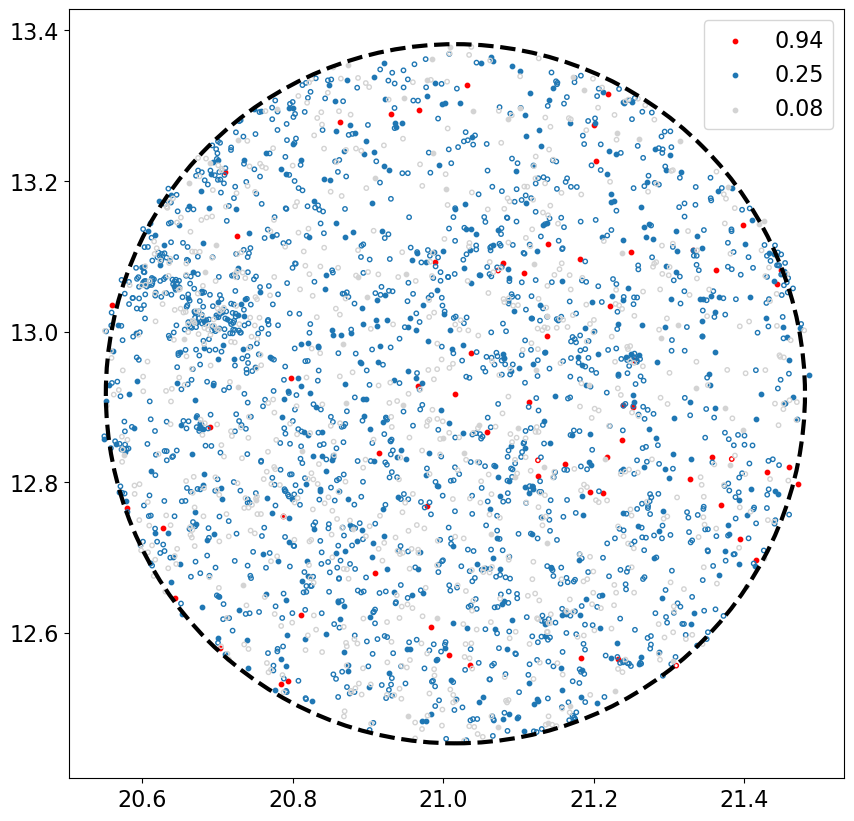

In [25]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)
ax.set_aspect('equal')
is_primary = target_score<=700.
is_relaxed = (target_score>700.)&(target_score<=1000.)
is_out = target_score>1000.
has_z = this_host['ZQUALITY']>=3.
pointsize = 10

ax.scatter ( this_host.loc[is_primary&has_z,'RA'], this_host.loc[is_primary&has_z,'DEC'], s=pointsize, color='r', label='%.2f'%((has_z&is_primary).sum()/is_primary.sum()))
ax.scatter ( this_host.loc[is_primary&~has_z,'RA'], this_host.loc[is_primary&~has_z,'DEC'], s=pointsize, fc='None', ec='r')

ax.scatter ( this_host.loc[is_relaxed&has_z,'RA'], this_host.loc[is_relaxed&has_z,'DEC'], s=pointsize, color='tab:blue', label='%.2f'%((has_z&is_relaxed).sum()/is_relaxed.sum()))
ax.scatter ( this_host.loc[is_relaxed&~has_z,'RA'], this_host.loc[is_relaxed&~has_z,'DEC'], s=pointsize, fc='None', ec='tab:blue',)

ax.scatter ( this_host.loc[is_out&has_z,'RA'], this_host.loc[is_out&has_z,'DEC'], s=pointsize, color='lightgrey', label='%.2f'%((has_z&is_out).sum()/is_out.sum()))
ax.scatter ( this_host.loc[is_out&~has_z,'RA'], this_host.loc[is_out&~has_z,'DEC'], s=pointsize, fc='None', ec='lightgrey',)

circ = patches.Circle ( (hosts[hosts['HOSTID']==hostname]['RA'], hosts[hosts['HOSTID']==hostname]['DEC']),
                         radius, facecolor="None", edgecolor='k', lw=3, ls='--')
ax.add_patch(circ)
#ax.scatter ( this_host.loc[has_z, 'RA'], this_host.loc[has_z,'DEC'], fc='None', ec='tab:blue', s=10,)
ax.legend()
#plt.colorbar()

In [28]:
gama_rlim = 19.8
saga_rlim = 20.75
saga_grlim = lambda r: 0.9 - 0.06*(r-14.) # must be bluer than <
saga_sblim = lambda r: 18.5 + 0.7*(r-14.) # must be fainter than >

In [38]:
from SAGA import utils
from SAGA.objects import cuts

In [305]:
clean['selection'] = 0
utils.fill_values_by_query(clean, cuts.main_targeting_cuts, {'selection':3})
saga_primary = clean[clean['selection']==3].to_pandas ().set_index('OBJID')

clean['selection'] = 0
utils.fill_values_by_query(clean, cuts.paper1_targeting_cut&~cuts.main_targeting_cuts, {'selection':2})
saga_paperone = clean[clean['selection']==2].to_pandas ().set_index('OBJID')

clean['selection'] = 0
utils.fill_values_by_query(clean, cuts.paper1_targeting_cut|cuts.main_targeting_cuts, {'selection':4})
saga_relaxed = clean[clean['selection']==4].to_pandas ().set_index('OBJID')

clean['selection'] = 0
utils.fill_values_by_query(clean, ~cuts.main_targeting_cuts&~cuts.paper1_targeting_cut, {'selection':1})
saga_out = clean[clean['selection']==1].to_pandas ().set_index('OBJID')

clean['selection'] = 0
utils.fill_values_by_query(clean, ~cuts.main_targeting_cuts, {'selection':5})
saga_notinpapertwo = clean[clean['selection']==5].to_pandas ().set_index('OBJID')

assert (saga_primary.shape[0] + saga_paperone.shape[0] + saga_out.shape[0]) == len(clean)

In [363]:
saga_paperone['']

OBJID
904461150000003517    0.371746
904461150000003679    0.455393
904461150000003926    0.564436
904461150000004085    0.369751
904461150000004296    0.332134
                        ...   
904488100000004511    0.574677
904488100000004723    0.454393
904488100000004895    0.046497
904488100000004958    0.435587
904488100000005175    0.454807
Name: rz, Length: 37437, dtype: float32

In [315]:
utils.fill_values_by_query(clean, cuts.main_targeting_cuts|cuts.paper1_targeting_cut, {'selection':1})
utils.fill_values_by_query(clean, cuts.main_targeting_cuts, {'selection':2})

9430

In [326]:
#saga = SAGA.QuickStart(local_dir="../local_data/")
hosts = saga.host_catalog.load(include_stats=True)

In [327]:
paper3_hosts = saga.host_catalog.load(query="paper3", include_stats=True)

In [337]:
from astropy import constants as co

In [294]:
saga_l = [saga_primary, saga_paperone, saga_out, saga_notinpapertwo, saga_relaxed]

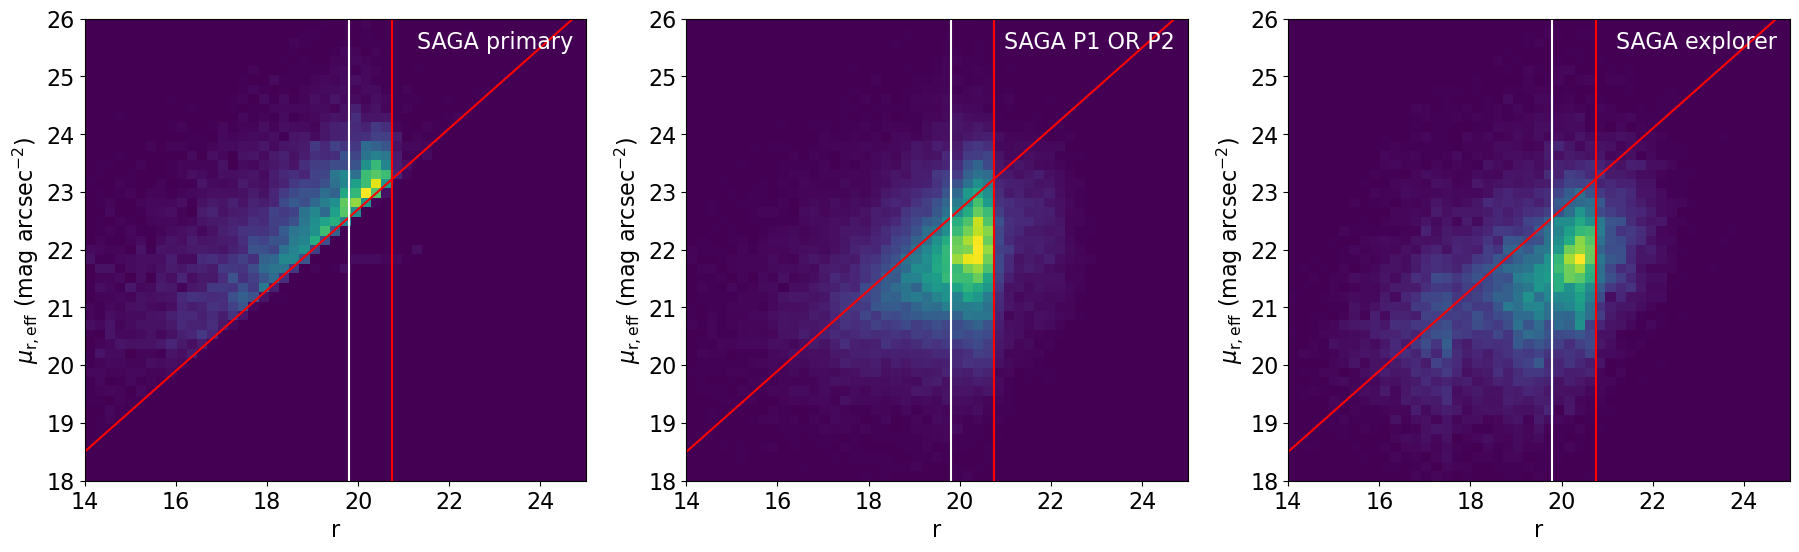

In [295]:
fig, axarr = plt.subplots(1,3,figsize=(22,6))
bins_l = [np.linspace(14.,25.,50), np.linspace(18.,26.,50)]
axarr[0].hist2d ( saga_primary['r_mag'], saga_primary['sb_r'], bins=bins_l)
axarr[1].hist2d ( saga_relaxed['r_mag'], saga_relaxed['sb_r'], bins=bins_l)
axarr[2].hist2d ( saga_out['r_mag'], saga_out['sb_r'], bins=bins_l)

text = ['SAGA primary', 'SAGA P1 OR P2', 'SAGA explorer']
for idx,ax in enumerate(axarr.flatten()):
    ax.plot ( bins_l[0], saga_sblim(bins_l[0]), color='r' )
    ax.text ( 0.975, 0.975, text[idx], ha='right', va='top', color='w', transform=ax.transAxes )
    ax.axvline(gama_rlim, color='w')
    ax.axvline(saga_rlim, color='r')
    ax.set_xlabel('r')
    ax.set_ylabel(r'$\mu_{\rm r,eff}$ (mag arcsec$^{-2}$)')

In [296]:
g_matrix = [[0., 0., 0., 0.],
                [-0.900332, 3.97338, 0.774394, -1.09389],
                [3.65877, -8.04213, 11.0321, 0.781176],
                [-16.7457, -31.1241, -17.5553, 0],
                [87.3565, 71.5801, 0., 0.],
                [-123.671, 0, 0, 0]]
g_matrix = np.asarray(g_matrix)

r_matrix = [[0.,0.,0.,0.],
            [-1.61294, 3.81378, -3.56114, 2.47133],
            [9.13285, 9.85141, -5.1432, -7.02213],
            [-81.8341, -30.3631, 38.5052, 0.0],
            [250.732, -25.0159, 0.0, 0.0],
            [-215.377, 0.0, 0.0, 0.0]]
r_matrix = np.asarray(r_matrix)
            
kcorr_d = {'g':g_matrix,'r':r_matrix}
logml = lambda gr: 1.65*gr - 0.66

def kcorrect ( z, gr, bandpass ):
    if isinstance(z, float):
        kcorr_est = 0.
    else:
        kcorr_est = np.zeros(z.shape)
    for x_idx in range(5):
        for y_idx in range(4):
            coeff = kcorr_d[bandpass][x_idx, y_idx]
            term = coeff * z**x_idx * gr**y_idx
            kcorr_est += term
    return kcorr_est

def colormass_masses ( z, obsgr, Mr, zp_g = 5.11 ):
    kcorr_g = kcorrect ( z, obsgr, 'g' )
    kcorr_r = kcorrect ( z, obsgr, 'r' )
    gr_restframe = obsgr + kcorr_g - + kcorr_r
    M_g = Mr + gr_restframe
    
    loglum_g = (M_g-zp_g)/-2.5
    logsmass = logml(gr_restframe) + loglum_g    
    return logsmass

In [297]:
for saga in saga_l:
    saga['cm_mass'] = colormass_masses ( saga['SPEC_Z'], saga['gr'], saga['Mr'] )

NameError: name 'gama_sl' is not defined

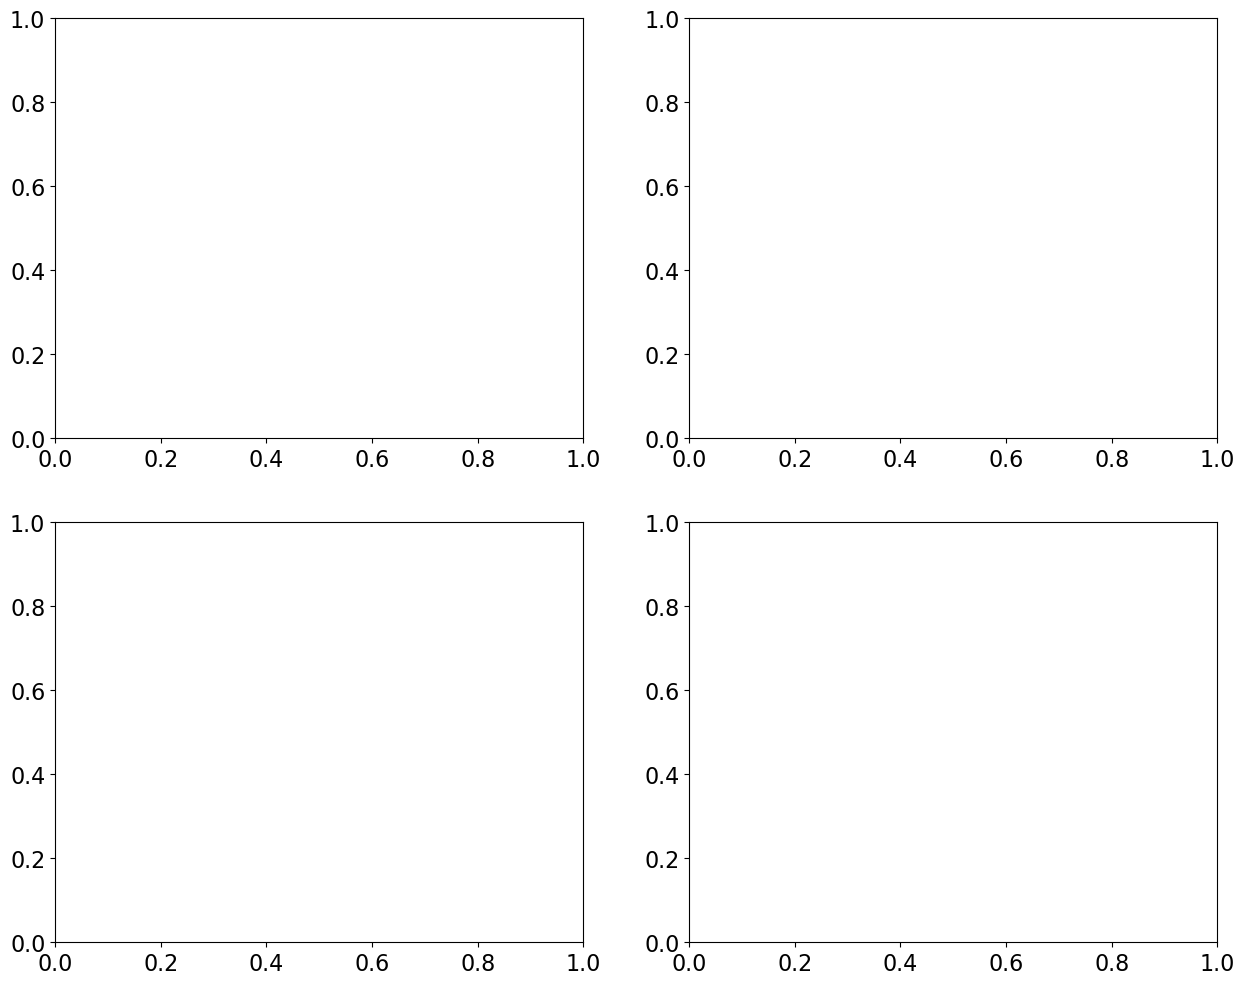

In [359]:
fig, axarr = plt.subplots(2,2,figsize=(15,12))
bins_l = [np.linspace(14.,25.,50), np.linspace(18.,26.,50)]
axarr[0,0].hist2d ( gama_sl['GALMAG_r'], gama_sl['GALMUE_r'], bins=bins_l)
axarr[0,1].hist2d ( saga_gl['r_mag'], saga_gl['sb_r'], bins=bins_l)
axarr[1,0].hist2d ( gama['GALMAG_r'], gama['GALMUE_r'], bins=bins_l)
axarr[1,1].hist2d ( lowz['r_mag'], lowz['sb_r'], bins=bins_l)

text = ['GAMA w. SAGA-like cuts', 'SAGA w. GAMA-like cuts', 'GAMA','SAGA']
for idx,ax in enumerate(axarr.flatten()):
    ax.plot ( bins_l[0], saga_sblim(bins_l[0]), color='r' )
    ax.text ( 0.975, 0.975, text[idx], ha='right', va='top', color='w', transform=ax.transAxes )
    ax.axvline(gama_rlim, color='w')
    ax.axvline(saga_rlim, color='r')
    ax.set_xlabel('r')
    ax.set_ylabel(r'$\mu_{\rm r,eff}$ (mag arcsec$^{-2}$)')

NameError: name 'gama_sl' is not defined

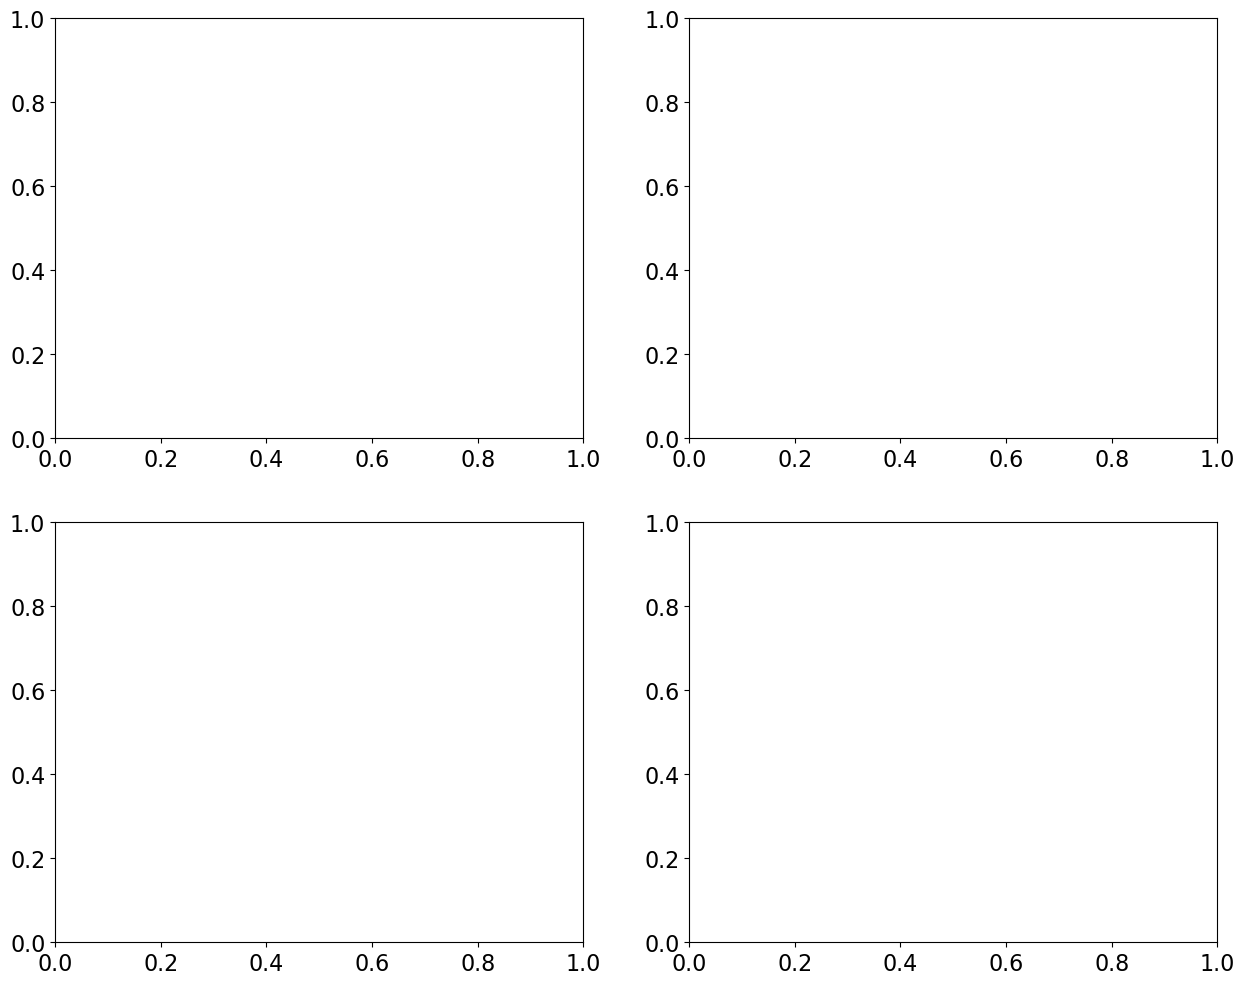

In [133]:
fig, axarr = plt.subplots(2,2,figsize=(15,12))
bins_l = [np.linspace(14.,25.,50), np.linspace(-0.2,1.1,50)]
axarr[0,0].hist2d ( gama_sl['GALMAG_r'], gama_sl['gminusr'], bins=bins_l)
axarr[0,1].hist2d ( saga_gl['r_mag'], saga_gl['gr'], bins=bins_l)
axarr[1,0].hist2d ( gama['GALMAG_r'], gama['gminusr'], bins=bins_l)
axarr[1,1].hist2d ( lowz['r_mag'], lowz['gr'], bins=bins_l)

text = ['GAMA w. SAGA-like cuts', 'SAGA w. GAMA-like cuts', 'GAMA','SAGA']
for idx,ax in enumerate(axarr.flatten()):
    ax.plot ( bins_l[0], saga_grlim(bins_l[0]), color='r' )
    ax.text ( 0.975, 0.975, text[idx], ha='right', va='top', color='w', transform=ax.transAxes )
    ax.axvline(gama_rlim, color='w')
    ax.axhline(0.85, color='r', ls=':')
    ax.set_xlabel('r')
    ax.set_ylabel('g-r')

NameError: name 'gama_sl' is not defined

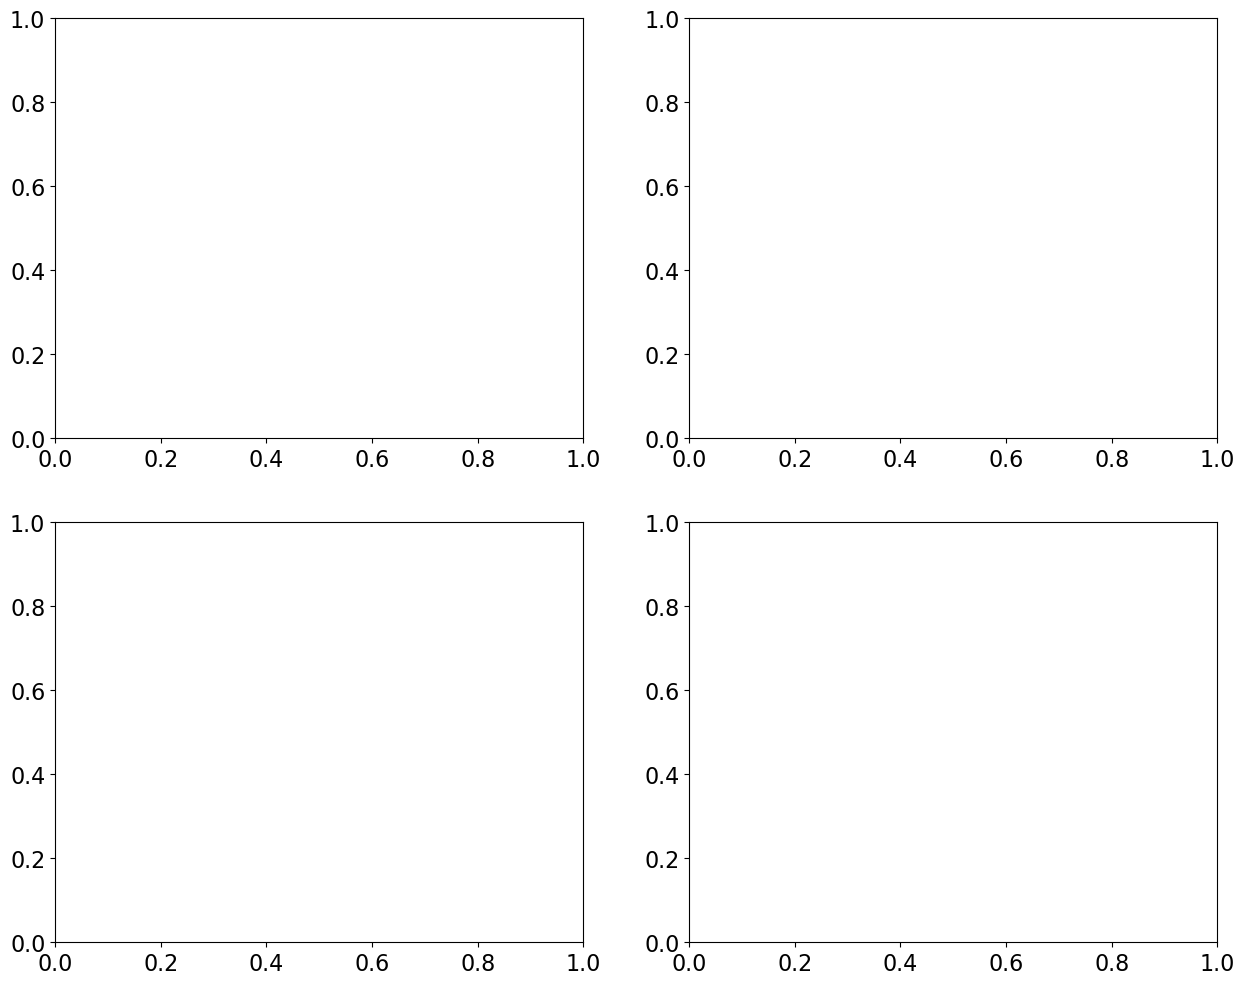

In [112]:
fig, axarr = plt.subplots(2,2,figsize=(15,12))
bins_l = [np.linspace(0., 0.2,50), np.linspace(-0.2,1.1,50)]
axarr[0,0].hist2d ( gama_sl['Z'], gama_sl['gminusr'], bins=bins_l)
axarr[0,1].hist2d ( saga_gl['SPEC_Z'], saga_gl['gr'], bins=bins_l)
axarr[1,0].hist2d ( gama['Z'], gama['gminusr'], bins=bins_l)
axarr[1,1].hist2d ( lowz['SPEC_Z'], lowz['gr'], bins=bins_l)



text = ['GAMA w. SAGA-like cuts', 'SAGA w. GAMA-like cuts', 'GAMA','SAGA']
for idx,ax in enumerate(axarr.flatten()):
    ax.plot ( bins_l[0], saga_grlim(bins_l[0]), color='r' )
    ax.text ( 0.975, 0.975, text[idx], ha='right', va='top', color='w', transform=ax.transAxes )
    ax.set_xlabel('z')
    ax.set_ylabel('g-r')
    ax.grid(color='w',ls=':')

In [172]:
midpts = lambda x: 0.5*(x[1:]+x[:-1])

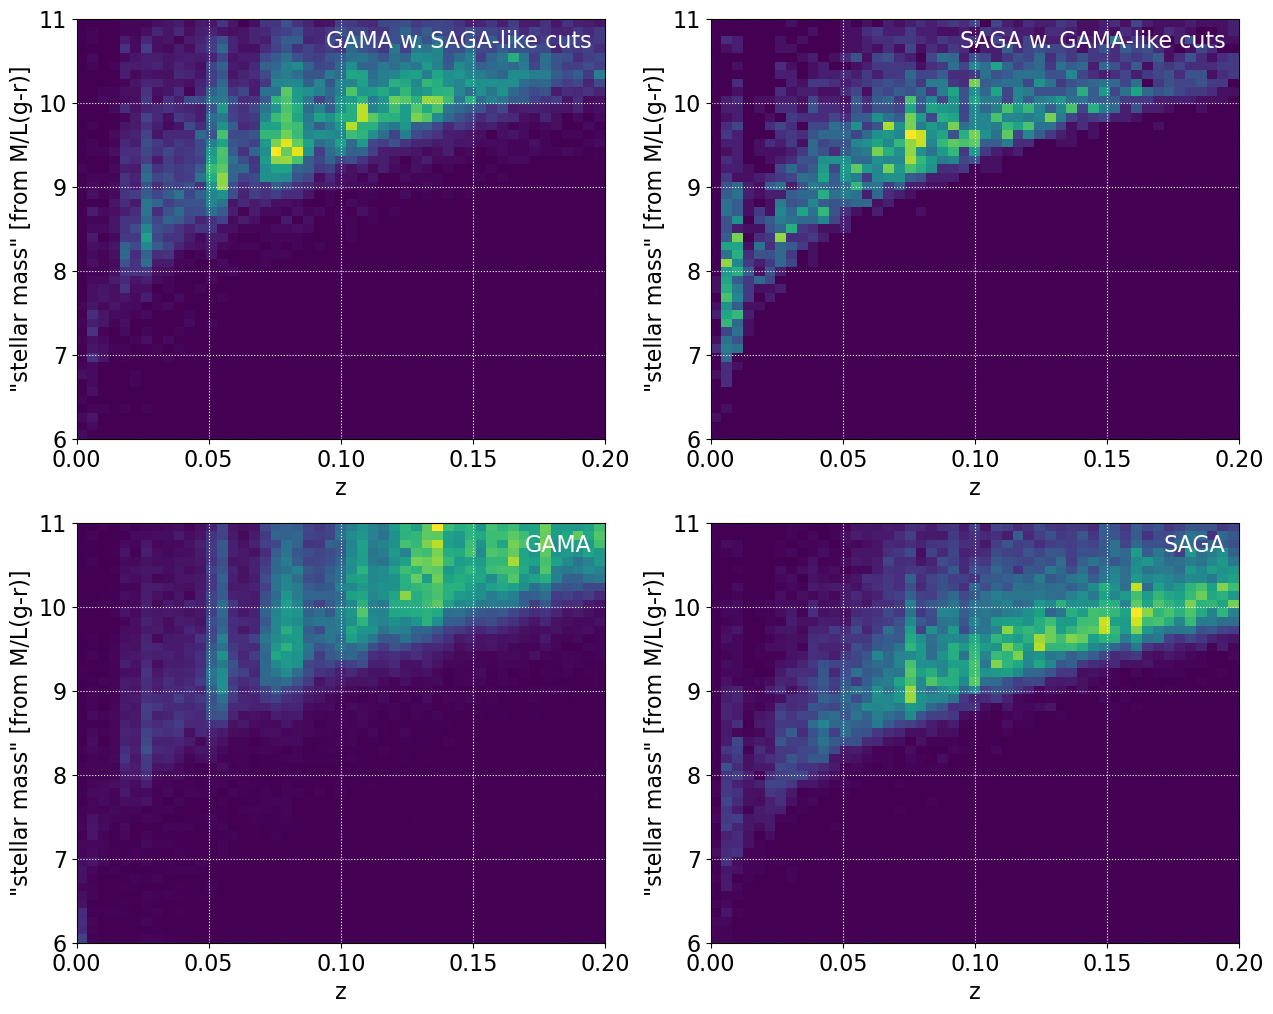

In [173]:
fig, axarr = plt.subplots(2,2,figsize=(15,6*2))
bins_l = [np.linspace(0., 0.2,50), np.linspace(6.,11.,50)]
out = axarr[0,0].hist2d ( gama_sl['Z'], gama_sl['cm_mass'], bins=bins_l)
axarr[1,0].hist2d( gama['Z'], gama['cm_mass'], bins=bins_l )
axarr[0,1].hist2d ( saga_gl['SPEC_Z'], saga_gl['cm_mass'], bins=bins_l)
axarr[1,1].hist2d( lowz['SPEC_Z'], lowz['cm_mass'], bins=bins_l )
#axarr[1].contour (  midpts(out[1]), midpts(out[2]), out[0].T, colors='r')

text = ['GAMA w. SAGA-like cuts', 'SAGA w. GAMA-like cuts', 'GAMA','SAGA']
for idx,ax in enumerate(axarr.flatten()):
    ax.plot ( bins_l[0], saga_grlim(bins_l[0]), color='r' )
    ax.text ( 0.975, 0.975, text[idx], ha='right', va='top', color='w', transform=ax.transAxes )
    #ax.axvline(gama_rlim, color='w')
    ax.set_xlabel('z')
    ax.set_ylabel('"stellar mass" [from M/L(g-r)]')
    ax.grid(color='w',ls=':')

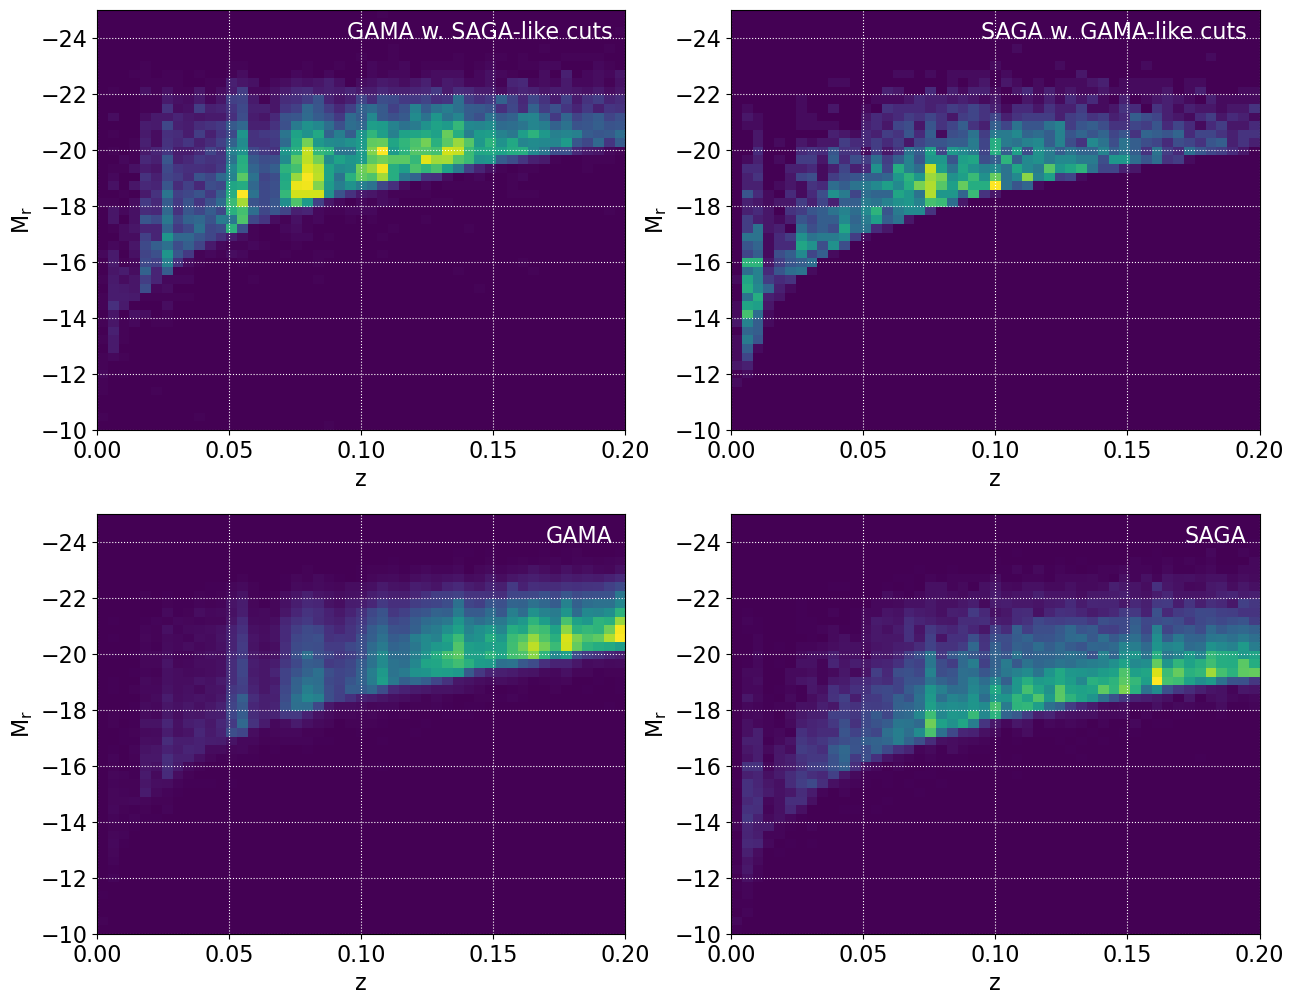

In [174]:
fig, axarr = plt.subplots(2,2,figsize=(15,6*2))
bins_l = [np.linspace(0., 0.2,50), np.linspace(-25,-10,50)]

out = axarr[0,0].hist2d ( gama_sl['Z'], gama_sl['absmag_r'], bins=bins_l)
axarr[1,0].hist2d( gama['Z'], gama['absmag_r'], bins=bins_l )
axarr[0,1].hist2d ( saga_gl['SPEC_Z'], saga_gl['Mr'], bins=bins_l)
axarr[1,1].hist2d( lowz['SPEC_Z'], lowz['Mr'], bins=bins_l )


text = ['GAMA w. SAGA-like cuts', 'SAGA w. GAMA-like cuts', 'GAMA','SAGA']
for idx,ax in enumerate(axarr.flatten()):
    ax.plot ( bins_l[0], saga_grlim(bins_l[0]), color='r' )
    ax.text ( 0.975, 0.975, text[idx], ha='right', va='top', color='w', transform=ax.transAxes )

    ax.set_xlabel('z')
    ax.set_ylabel(r'M$_{\rm r}$')
    ax.grid(color='w',ls=':')
    ax.set_ylim(ax.get_ylim()[::-1])

# Stats on SAGA primary targeting region

## Compare to full SAGA
TODO : what is the spectroscopic commitment of SAGA exploration mode? 50%?

/var/folders/py/1g64k0fx3rd03lcwckrdjbt80000gn/T/ipykernel_6443/3329769082.py:16: RuntimeWarning: invalid value encountered in divide
  recfrac = (phi_1*p1np2hist[0] + phi_2*p2hist[0])/(phi_1*p1np2hist[0] + phi_2*p2hist[0] + outhist[0])


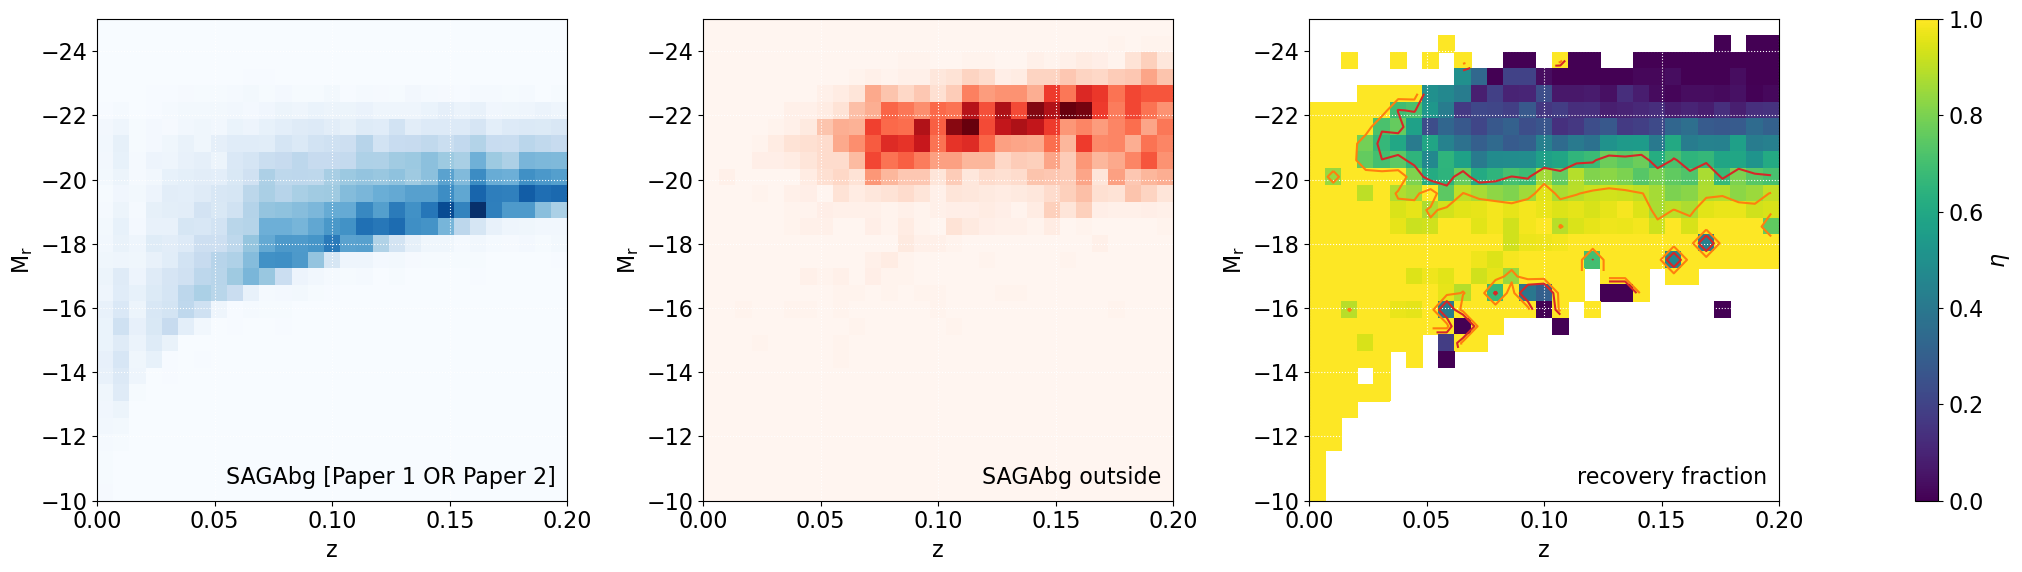

In [214]:
midpts = lambda x: 0.5*(x[1:]+x[:-1])
fig, axarr = plt.subplots(1,4,figsize=(5*4.1,6), gridspec_kw={'width_ratios':[1.,1.,1.,.05]})
nbins = 30
bins_l = [np.linspace(0., 0.2,nbins), np.linspace(-25,-10,nbins)]

inhist = axarr[0].hist2d ( saga_relaxed['SPEC_Z'], saga_relaxed['Mr'], bins=bins_l, cmap='Blues')
p1np2hist = np.histogram2d ( saga_paperone['SPEC_Z'], saga_paperone['Mr'], bins=bins_l)
p2hist =    np.histogram2d ( saga_primary['SPEC_Z'], saga_primary['Mr'], bins=bins_l, )

outhist = axarr[1].hist2d ( saga_out['SPEC_Z'], saga_out['Mr'], bins=bins_l, cmap='Reds')


phi_1 = outhist[0].sum () / p1np2hist[0].sum()
phi_2 = outhist[0].sum() / p2hist[0].sum()

recfrac = (phi_1*p1np2hist[0] + phi_2*p2hist[0])/(phi_1*p1np2hist[0] + phi_2*p2hist[0] + outhist[0])
#resource_factor = saga_out.shape[0] / saga_paperone.shape[0] #outhist[0].sum() / inhist[0].sum()
#saga_out.shape[0] / saga_paperone.shape[0] # a very clumsy accounting for the
# fact that more spectra were taken in exploration mode
#recfrac = inhist[0]*resource_factor/(inhist[0]*resource_factor + outhist[0])
im = axarr[2].pcolor ( inhist[1], inhist[2], recfrac.T, cmap='viridis' )
axarr[2].contour ( midpts(inhist[1]), midpts(inhist[2]), recfrac.T, colors=['tab:red','tab:orange'], levels=[.7, .9])
plt.colorbar(im, cax=axarr[-1], label=r'$\eta$')

text = ['SAGAbg [Paper 1 OR Paper 2]', 'SAGAbg outside', 'recovery fraction']
cc_l = ['k','k','k']
for idx,ax in enumerate(axarr.flatten()[:-1]):
    ax.text ( 0.975, 0.025, text[idx], ha='right', va='bottom', color=cc_l[idx], transform=ax.transAxes )

    ax.set_xlabel('z')
    ax.set_ylabel(r'M$_{\rm r}$')
    ax.grid(color='w',ls=':')
    ax.set_ylim(ax.get_ylim()[::-1])
plt.tight_layout ()
plt.savefig('../figures/SAGA_targeting.png')

/var/folders/py/1g64k0fx3rd03lcwckrdjbt80000gn/T/ipykernel_6443/1051899004.py:12: RuntimeWarning: invalid value encountered in divide
  recfrac = inhist[0]*resource_factor/(inhist[0]*resource_factor + outhist[0])


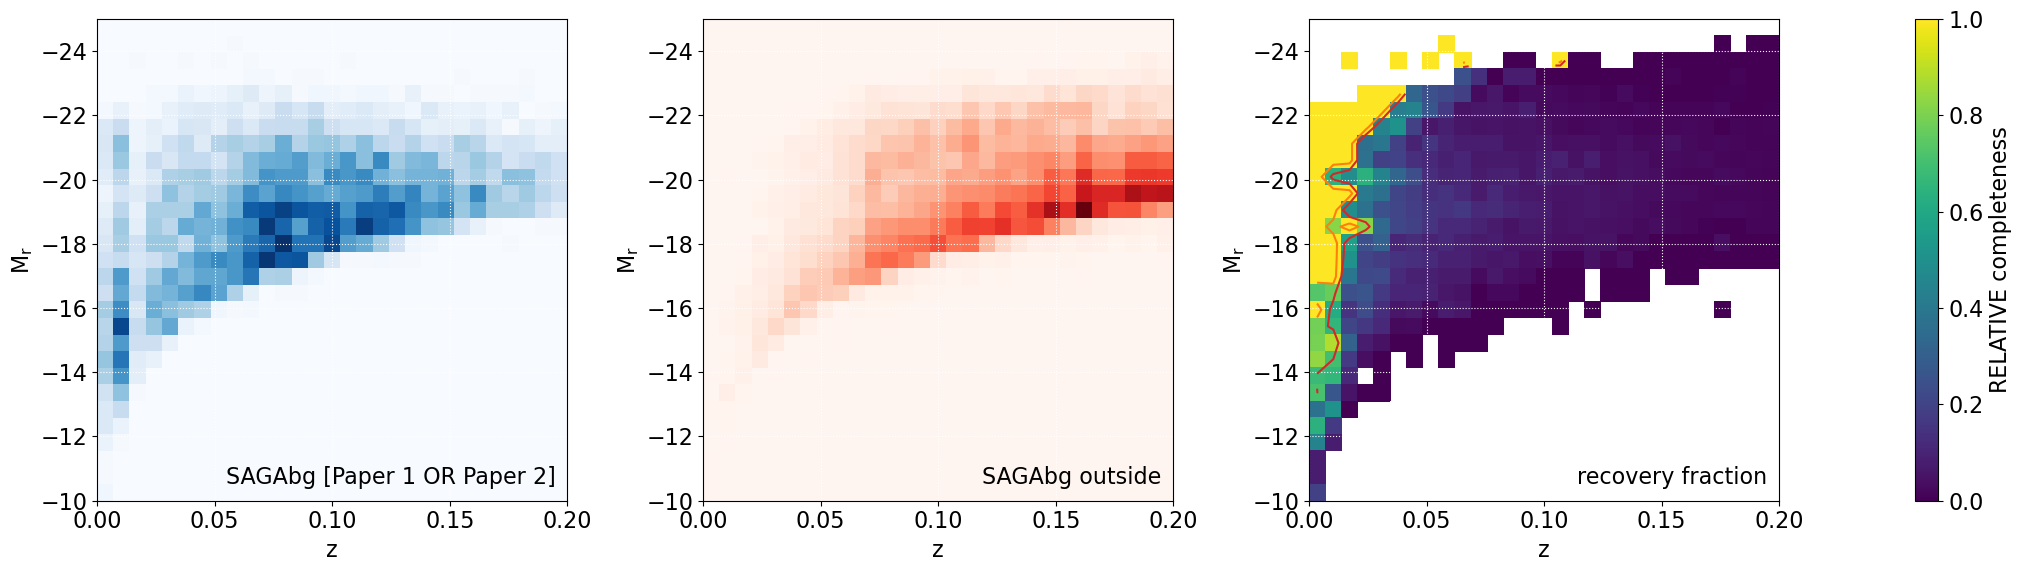

In [163]:
midpts = lambda x: 0.5*(x[1:]+x[:-1])
fig, axarr = plt.subplots(1,4,figsize=(5*4.1,6), gridspec_kw={'width_ratios':[1.,1.,1.,.05]})
nbins = 30
bins_l = [np.linspace(0., 0.2,nbins), np.linspace(-25,-10,nbins)]

inhist = axarr[0].hist2d ( saga_primary['SPEC_Z'], saga_primary['Mr'], bins=bins_l, cmap='Blues')
outhist = axarr[1].hist2d ( saga_notinpapertwo['SPEC_Z'], saga_notinpapertwo['Mr'], bins=bins_l, cmap='Reds')

resource_factor = saga_primary.shape[0] / saga_notinpapertwo.shape[0] #outhist[0].sum() / inhist[0].sum()
#saga_notinpapertwo.shape[0] / saga_primary.shape[0] # a very clumsy accounting for the
# fact that more spectra were taken in exploration mode
recfrac = inhist[0]*resource_factor/(inhist[0]*resource_factor + outhist[0])
im = axarr[2].pcolor ( inhist[1], inhist[2], recfrac.T, cmap='viridis' )
axarr[2].contour ( midpts(inhist[1]), midpts(inhist[2]), recfrac.T, colors=['tab:red','tab:orange'], levels=[.7, .9])
plt.colorbar(im, cax=axarr[-1], label='RELATIVE completeness')

text = ['SAGAbg [Paper 1 OR Paper 2]', 'SAGAbg outside', 'recovery fraction']
cc_l = ['k','k','k']
for idx,ax in enumerate(axarr.flatten()[:-1]):
    ax.text ( 0.975, 0.025, text[idx], ha='right', va='bottom', color=cc_l[idx], transform=ax.transAxes )

    ax.set_xlabel('z')
    ax.set_ylabel(r'M$_{\rm r}$')
    ax.grid(color='w',ls=':')
    ax.set_ylim(ax.get_ylim()[::-1])
plt.tight_layout ()
plt.savefig('../figures/SAGA_targeting-P2only.png')

/var/folders/py/1g64k0fx3rd03lcwckrdjbt80000gn/T/ipykernel_6443/2171224193.py:13: RuntimeWarning: invalid value encountered in divide
  recfrac = inhist[0]*resource_factor/(inhist[0]*resource_factor + outhist[0])


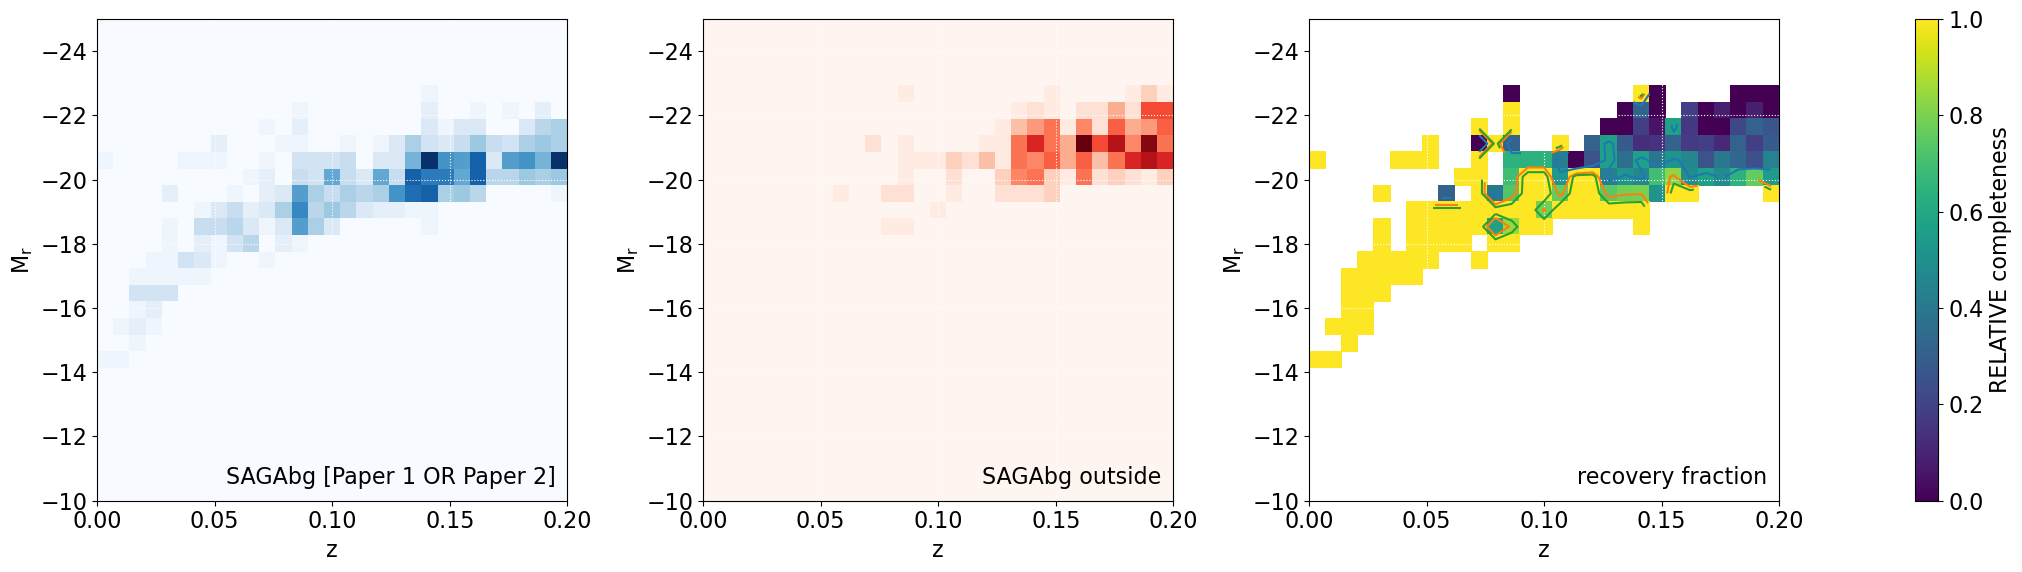

In [143]:
midpts = lambda x: 0.5*(x[1:]+x[:-1])
fig, axarr = plt.subplots(1,4,figsize=(5*4.1,6), gridspec_kw={'width_ratios':[1.,1.,1.,.05]})
nbins = 30
bins_l = [np.linspace(0., 0.2,nbins), np.linspace(-25,-10,nbins)]

from_gama = 'TELNAME=="GAMA"'
inhist = axarr[0].hist2d ( saga_paperone.query(from_gama)['SPEC_Z'], saga_paperone.query(from_gama)['Mr'], bins=bins_l, cmap='Blues')
outhist = axarr[1].hist2d ( saga_out.query(from_gama)['SPEC_Z'],  saga_out.query(from_gama)['Mr'], bins=bins_l, cmap='Reds')

resource_factor = saga_out.shape[0] / saga_paperone.shape[0] #outhist[0].sum() / inhist[0].sum()
#saga_out.shape[0] / saga_paperone.shape[0] # a very clumsy accounting for the
# fact that more spectra were taken in exploration mode
recfrac = inhist[0]*resource_factor/(inhist[0]*resource_factor + outhist[0])
im = axarr[2].pcolor ( inhist[1], inhist[2], recfrac.T, cmap='viridis' )
axarr[2].contour ( midpts(inhist[1]), midpts(inhist[2]), recfrac.T, colors=['C0','C1','C2'], levels=[0.5,0.8,0.9])
plt.colorbar(im, cax=axarr[-1], label='RELATIVE completeness')

text = ['SAGAbg [Paper 1 OR Paper 2]', 'SAGAbg outside', 'recovery fraction']
cc_l = ['k','k','k']
for idx,ax in enumerate(axarr.flatten()[:-1]):
    ax.text ( 0.975, 0.025, text[idx], ha='right', va='bottom', color=cc_l[idx], transform=ax.transAxes )

    ax.set_xlabel('z')
    ax.set_ylabel(r'M$_{\rm r}$')
    ax.grid(color='w',ls=':')
    ax.set_ylim(ax.get_ylim()[::-1])
plt.tight_layout ()

/var/folders/py/1g64k0fx3rd03lcwckrdjbt80000gn/T/ipykernel_6443/448702304.py:11: RuntimeWarning: invalid value encountered in divide
  recfrac = inhist[0]*resource_factor/(inhist[0]*resource_factor+outhist[0])


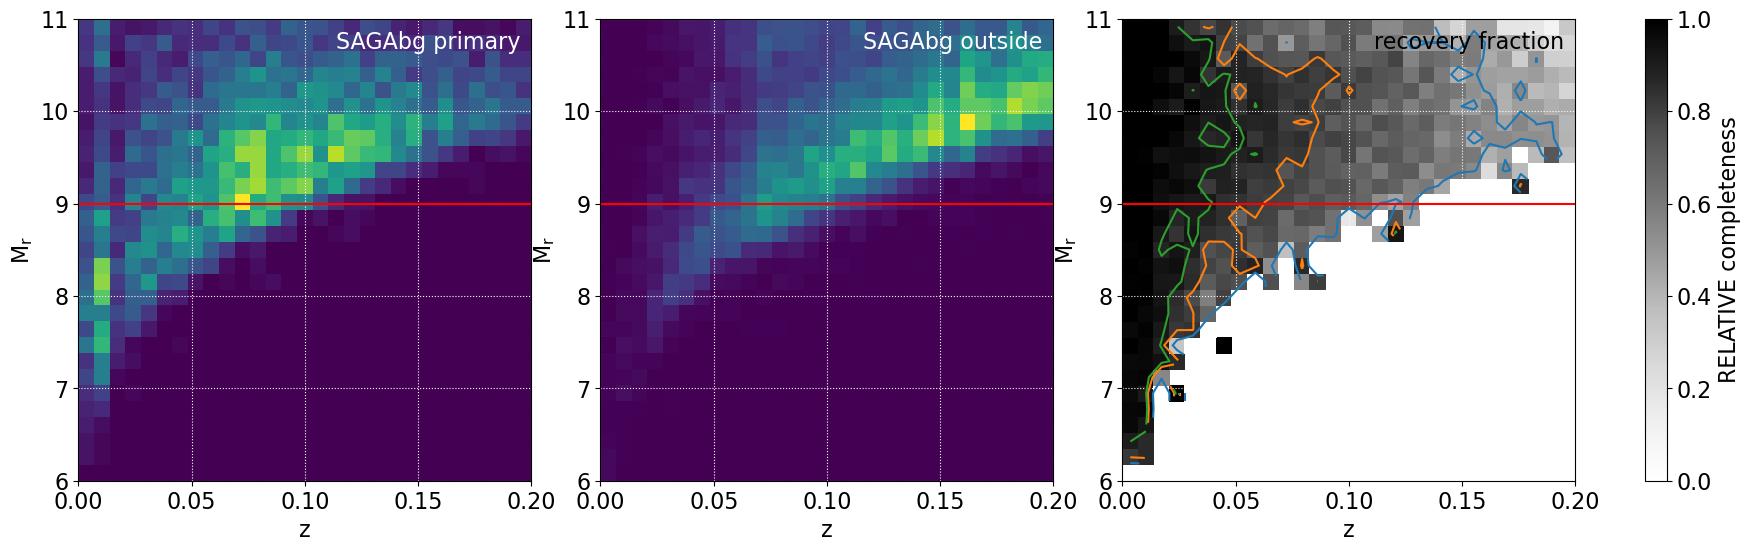

In [122]:
fig, axarr = plt.subplots(1,4,figsize=(5*4.1,6), gridspec_kw={'width_ratios':[1.,1.,1.,.05]})
nbins = 30
bins_l = [np.linspace(0., 0.2,nbins), np.linspace(6.,11.,nbins)]

inhist = axarr[0].hist2d ( saga_primary['SPEC_Z'], saga_primary['cm_mass'], bins=bins_l)
outhist = axarr[1].hist2d ( saga_out['SPEC_Z'], saga_out['cm_mass'], bins=bins_l)

resource_factor = saga_out.shape[0] / saga_primary.shape[0] #outhist[0].sum() / inhist[0].sum()
#saga_out.shape[0] / saga_primary.shape[0] # a very clumsy accounting for the
# fact that more spectra were taken in exploration mode
recfrac = inhist[0]*resource_factor/(inhist[0]*resource_factor+outhist[0])
im = axarr[2].pcolor ( inhist[1], inhist[2], recfrac.T, cmap='Greys' )
axarr[2].contour ( midpts(inhist[1]), midpts(inhist[2]), recfrac.T, colors=['C0','C1','C2'], levels=[0.5,0.8,0.9])
plt.colorbar(im, cax=axarr[-1], label='RELATIVE completeness')

text = ['SAGAbg primary', 'SAGAbg outside', 'recovery fraction']
cc_l = ['w','w','k']
for idx,ax in enumerate(axarr.flatten()[:-1]):
    ax.text ( 0.975, 0.975, text[idx], ha='right', va='top', color=cc_l[idx], transform=ax.transAxes )

    ax.set_xlabel('z')
    ax.set_ylabel(r'M$_{\rm r}$')
    ax.grid(color='w',ls=':')
    ax.axhline(9.,color='r')

# Some stats noodling

In [91]:
# how probable is it to draw a negative number if 
# samples are unbalanced
Ux = np.random.uniform(0.,10.,100000)
ax = np.random.normal(5.,1.,1000)

In [116]:
pinside = lambda x,m=5.,s=1.: (2.*np.pi*s**2)**(-0.5) * np.exp(-(x-m)**2/(2.*s**2))
puniform = lambda x, xmin=0., xmax=10.: np.ones_like(x) / (xmax-xmin)

In [93]:
bins = np.arange(0.,10.,.25)

In [94]:
counts_ax = np.zeros_like(bins)
assns_ax, _counts_ax = np.unique(np.digitize(ax, bins), return_counts=True)
counts_ax[assns_ax] = _counts_ax
assns_ux, counts_ux = np.unique(np.digitize(Ux, bins), return_counts=True)

In [106]:
(Ux<5.).sum()

49787

In [109]:
.5*ax.size / (.5 * Ux.size) * Ux.size/ax.size

1.0

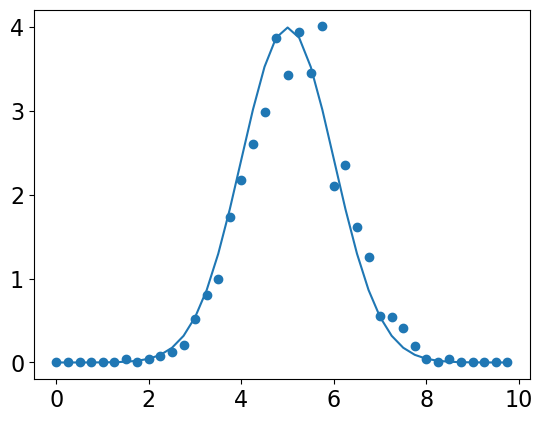

In [120]:
plt.plot(bins, pinside(bins)/puniform(bins))
#plt.plot(bins, puniform(bins))
plt.scatter(bins, counts_ax/counts_ux * Ux.size/ax.size)


In [144]:
#pinside = lambda x,m=5.,s=1.: (2.*np.pi*s**2)**(-0.5) * np.exp(-(x-m)**2/(2.*s**2))
p1 = lambda x: pinside(x, 5.,1.)
p2 = lambda x: pinside(x, 6.,2.)
s1 = np.random.normal(5.,1.,10000)
s2 = np.random.normal(6.,2.,12000)
bins = np.arange(0.,15.,.25)
counts_s1 = np.zeros_like(bins)
assns_s1, _counts_s1 = np.unique(np.digitize(s1, bins), return_counts=True)
counts_s1[assns_s1] = _counts_s1

counts_s2 = np.zeros_like(bins)
assns_s2, _counts_s2 = np.unique(np.digitize(s2, bins), return_counts=True)
counts_s2[assns_s2] = _counts_s2

/var/folders/py/1g64k0fx3rd03lcwckrdjbt80000gn/T/ipykernel_2013/2390003158.py:2: RuntimeWarning: invalid value encountered in divide
  plt.scatter(bins, counts_s1/counts_s2 * counts_s2.sum()/counts_s1.sum() )


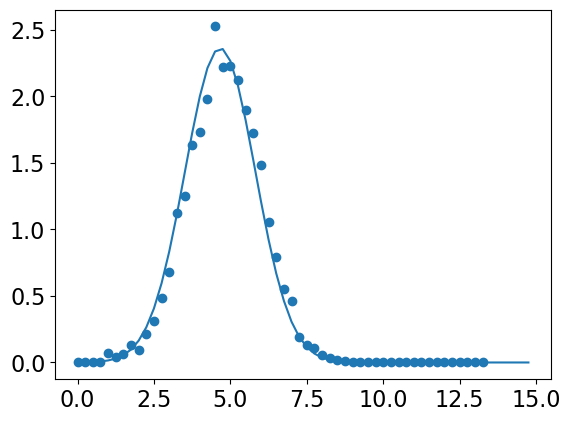

In [147]:
plt.plot(bins,p1(bins)/p2(bins))
plt.scatter(bins, counts_s1/counts_s2 * counts_s2.sum()/counts_s1.sum() )

# GAMA internal comparison

In [214]:
#c_gama_sl = gama['gminusr'] <= saga_grlim(gama['GALMAG_r'])
#c_gama_sl &= gama['GALMUE_r'] >= saga_sblim(gama['GALMAG_r'])
#c_gama_sl &= gama['GALMAG_r'] <= gama_rlim # apply GAMA's own maglim
#gama_sl = gama.loc[c_gama_sl].copy() # GAMA, SAGA-like

In [223]:
#gama_out = gama.loc[gama['GALMAG_r']<=gama_rlim]
# lowz.loc[~c_saga_primary].copy()
gama_out = gama.loc[~c_gama_sl]
gama_out = gama_out.loc[gama_out['GALMAG_r']<=gama_rlim].copy()

/var/folders/py/1g64k0fx3rd03lcwckrdjbt80000gn/T/ipykernel_4843/2809995650.py:9: RuntimeWarning: invalid value encountered in divide
  recfrac = inhist[0]/(outhist[0]+inhist[0])


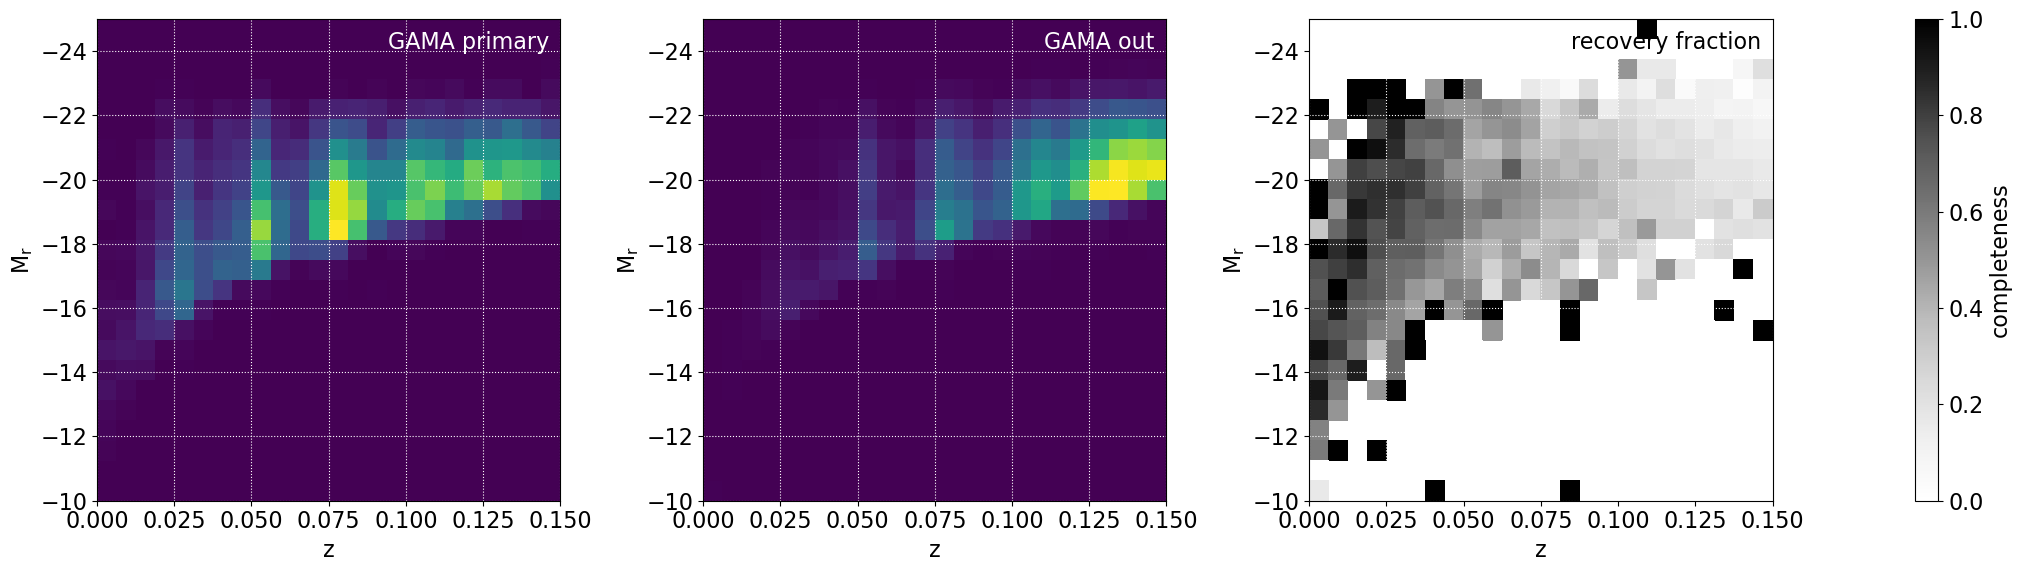

In [237]:
fig, axarr = plt.subplots(1,4,figsize=(5*4.1,6), gridspec_kw={'width_ratios':[1.,1.,1.,.05]})
nbins = 25
bins_l = [np.linspace(0., 0.15,nbins), np.linspace(-25,-10,nbins)]

inhist = axarr[0].hist2d ( gama_sl['Z'], gama_sl['absmag_r'], bins=bins_l)
outhist = axarr[1].hist2d ( gama_out['Z'], gama_out['absmag_r'], bins=bins_l)

# fact that more spectra were taken in exploration mode
recfrac = inhist[0]/(outhist[0]+inhist[0])
im = axarr[2].pcolor ( inhist[1], inhist[2], recfrac.T, cmap='Greys' )
#axarr[2].contour ( midpts(inhist[1]), midpts(inhist[2]), recfrac.T, colors=['C0','C1','C2'], levels=[0.5,0.8,0.9])
plt.colorbar(im, cax=axarr[-1], label='completeness')

text = ['GAMA primary', 'GAMA out', 'recovery fraction']
cc_l = ['w','w','k']
for idx,ax in enumerate(axarr.flatten()[:-1]):
    ax.text ( 0.975, 0.975, text[idx], ha='right', va='top', color=cc_l[idx], transform=ax.transAxes )

    ax.set_xlabel('z')
    ax.set_ylabel(r'M$_{\rm r}$')
    ax.grid(color='w',ls=':')
    ax.set_ylim(ax.get_ylim()[::-1])
plt.tight_layout ()

/var/folders/py/1g64k0fx3rd03lcwckrdjbt80000gn/T/ipykernel_4843/3343169829.py:9: RuntimeWarning: invalid value encountered in divide
  recfrac = inhist[0]/(outhist[0]+inhist[0])


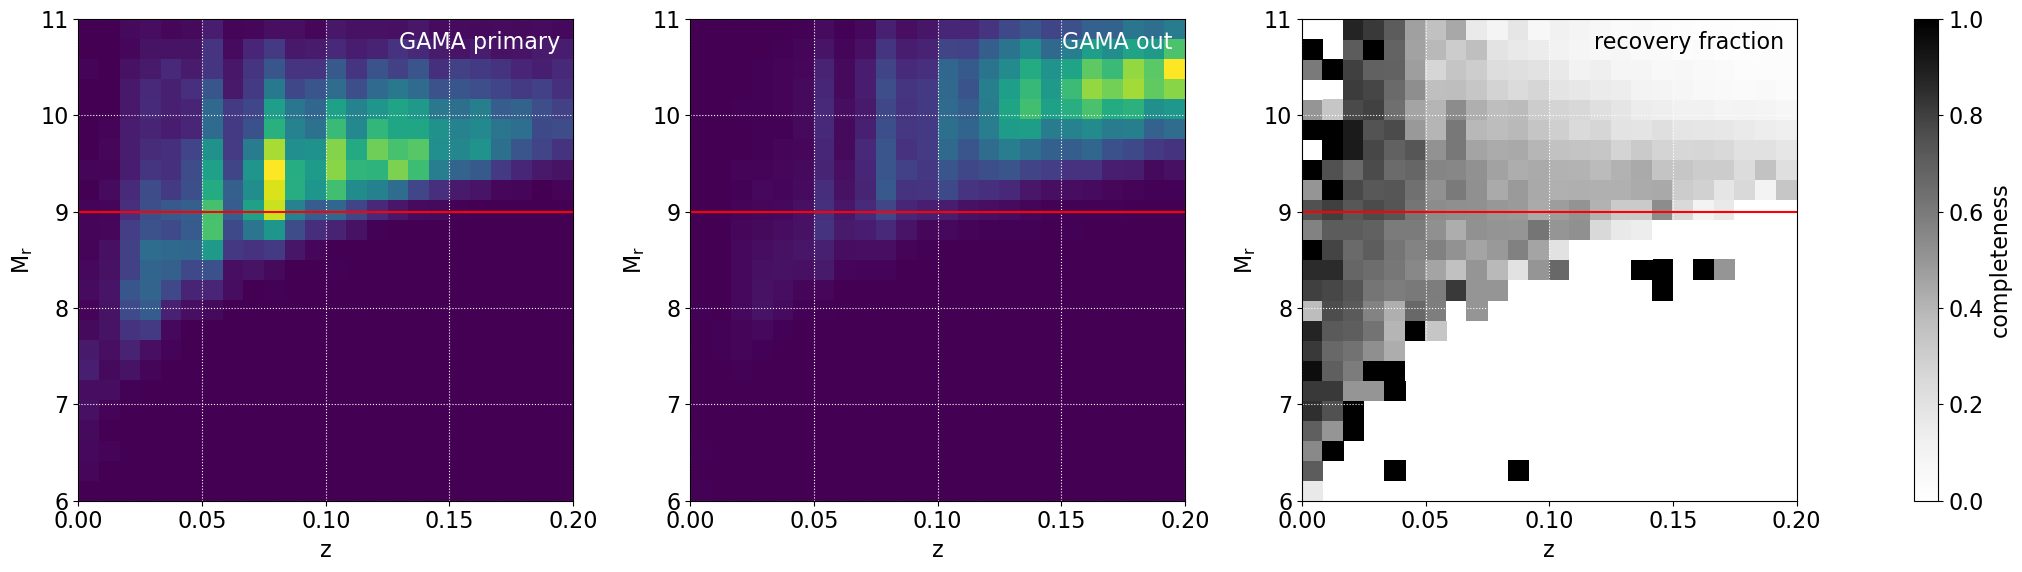

In [245]:
fig, axarr = plt.subplots(1,4,figsize=(5*4.1,6), gridspec_kw={'width_ratios':[1.,1.,1.,.05]})
nbins = 25
bins_l = [np.linspace(0., 0.2,nbins), np.linspace(6.,11.,nbins)]

inhist = axarr[0].hist2d ( gama_sl['Z'], gama_sl['logmstar'], bins=bins_l)
outhist = axarr[1].hist2d ( gama_out['Z'], gama_out['logmstar'], bins=bins_l)

# fact that more spectra were taken in exploration mode
recfrac = inhist[0]/(outhist[0]+inhist[0])
im = axarr[2].pcolor ( inhist[1], inhist[2], recfrac.T, cmap='Greys' )
#axarr[2].contour ( midpts(inhist[1]), midpts(inhist[2]), recfrac.T, colors=['C0','C1','C2'], levels=[0.5,0.8,0.9])
plt.colorbar(im, cax=axarr[-1], label='completeness')

text = ['GAMA primary', 'GAMA out', 'recovery fraction']
cc_l = ['w','w','k']
for idx,ax in enumerate(axarr.flatten()[:-1]):
    ax.text ( 0.975, 0.975, text[idx], ha='right', va='top', color=cc_l[idx], transform=ax.transAxes )
    ax.set_xlabel('z')
    ax.set_ylabel(r'M$_{\rm r}$')
    ax.grid(color='w',ls=':')
    ax.axhline(9.,color='r')
    
plt.tight_layout ()